# Multilayer Neural Network

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.utils as skutils
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

In [2]:
class Multilayer:

    def __init__(self, l_in, l_hidden, seed=np.random.randint(1000), alpha=0.01, l2_lambda=0):
        self.alpha = alpha
        self.l2_lambda = l2_lambda
        self.m = [l_in] + list(l_hidden) + [1]  # neurons per layer
        self.L = len(self.m)  # number of layers

        self.fa = {}  # activation functions per layer
        self.fd = {}  # activation function derivatives per layer

        l = self.L - 1  # last layer activation
        self.fa[l] = Multilayer.a_sigmoid
        self.fd[l] = Multilayer.d_sigmoid

        # hidden layer activations
        for l in range(1, self.L - 1):
            self.fa[l] = Multilayer.a_relu
            self.fd[l] = Multilayer.d_relu

        self.A = {}  # activation values per layer per neuron
        self.Z = {}  # weighted inputs per layer per neuron
        self.W = {}  # weights per layer per neuron (columns)
        self.B = {}  # biases per layer per neuron
        self.C = {}  # cost per epoch
        self.G = []  # gradient check
        
        np.random.seed(seed)
        for l in range(1, self.L):
            self.W[l] = np.random.normal(loc=0, scale=0.01, size=(self.m[l-1], self.m[l]))
            self.B[l] = [np.random.normal(loc=0, scale=0.01, size=self.m[l])]
            
    def fit(self, X, y, max_epoch=1000, batch_size=None, gradient_check=False):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        current_epoch = 0

        while current_epoch < max_epoch:
            current_epoch += 1
            for Xb, yb in Multilayer.create_batches(X, y, batch_size):
                self.Z, self.A = self.forward_pass({0: Xb}, self.W, self.B)
                self.W, self.B = self.backward_pass(self.Z, self.A, yb)
                self.C[current_epoch] = self.cost(X, y, self.W, self.B)
                if gradient_check:
                    self.gradient_check(X, y)

        return self

    def forward_pass(self, A, W, B, Z={}):
        # Step 1
        for l in range(1, self.L):
            Z[l] = A[l-1].dot(W[l]) + B[l]
            A[l] = self.fa[l](Z[l])

        return Z, A

    def backward_pass(self, Z, A, y):
        W, B = self.W.copy(), self.B.copy()
        delta_A, delta_Z, delta_W, delta_B = {}, {}, {}, {}

        for l in range(self.L - 1, 0, -1):
            # Step 2. A
            if l == self.L - 1:
                delta_A[l] = ((1 - y) / (1 - A[l])) - (y / A[l])
                delta_Z[l] = A[l] - y  # delta_A[l] * self.fd[l](Z[l])
            else:
                delta_A[l] = delta_Z[l+1].dot(W[l+1].T)
                delta_Z[l] = delta_A[l] * self.fd[l](Z[l])

            # Step 2. B
            delta_W[l] = A[l-1].T.dot(delta_Z[l]) + ((self.l2_lambda / 2) * (W[l] ** 2))
            delta_B[l] = delta_Z[l].sum() / len(delta_Z[l])

        # Step 3.

        for l in range(1, self.L):
            W[l] -= self.alpha * delta_W[l]
            B[l] -= self.alpha * delta_B[l]

        return W, B

    def predict(self, X, threshold=0.5):
        _, A = self.forward_pass({0: np.array(X)}, self.W, self.B)
        return Multilayer.q_sigmoid(A[self.L - 1], threshold)[:, 0]

    def score(self, X, y, threshold=0.5):
        return accuracy_score(y, self.predict(X, threshold))

    def cost(self, X, y, W, B):
        _, A = self.forward_pass({0: np.array(X)}, W, B)
        y_cap = A[self.L - 1]
        return -((y * np.log(y_cap)) + (1 - y) * np.log(1 - y_cap)).sum()

    def gradient_check(self, X, y, eps=1e-7):    
        theta = [self.W] + [self.B]
        
        for l1 in range(len(theta)):  # For each W or B
            for l2 in theta[l1]:  # For each layer (dict key)
                for l3 in range(len(theta[l1][l2])):  # For each neuron
                    for l4 in range(len(theta[l1][l2][l3])):  # For each parameter
                        i = theta[l1][l2][l3][l4]  # original parameter

                        theta[l1][l2][l3][l4] = i + eps
                        W, B = theta
                        costPlus = self.cost(X, y, W, B)
                        
                        theta[l1][l2][l3][l4] = i - eps
                        W, B = theta
                        costMinus = self.cost(X, y, W, B)
                        
                        theta[l1][l2][l3][l4] = i  # restore parameter
                        self.G.append((costPlus - costMinus) / 2 * eps)
        
    def create_theta(W, B):
        return 
        
    def slice_theta(theta):
        W, B = theta
        return W, B
        
    def create_batches(X, y, batch_size):
        Xb, yb = skutils.shuffle(X, y)
        batches = (int)(len(X) / (batch_size or len(X)))
        Xb = np.array_split(Xb, batches)
        yb = np.array_split(yb, batches)
        return zip(Xb, yb)

    def q_sigmoid(a, threshold=0.5):  # quantizer
        return np.where(a < threshold, 0, 1)

    def a_sigmoid(z):  # logistic function
        return 1 / (1 + np.exp(-z))

    def d_sigmoid(z):  # sigmoid derivative (2.A validation)
        a = Multilayer.a_sigmoid(z)
        return a * (1 - a)

    def a_relu(z):  # rectified linear unit
        return np.where(z > 0, z, 0)

    def d_relu(z):  # relu derivative
        return np.where(z > 0, 1, 0)

## XOR Dataset

In [3]:
X = np.random.randn(500, 2)
y = np.where(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), 1, 0)

In [4]:
model = Multilayer(l_in=2, l_hidden=[3], seed=1, alpha=0.01) 
model.fit(X, y, max_epoch=80, batch_size=20, gradient_check=True)

In [5]:
max(model.G)

5.615376622358781e-13

### Predict

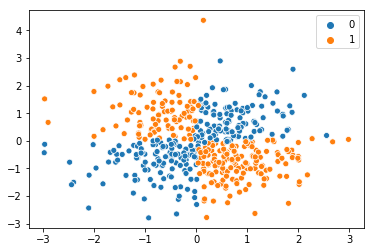

In [6]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=model.predict(X))

### Cost

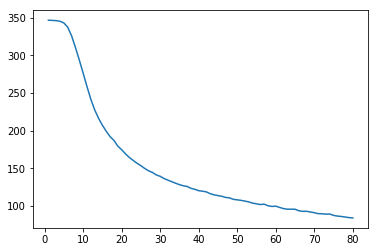

In [7]:
sns.lineplot(x=list(model.C.keys()), y=list(model.C.values()))

### Accuracy

In [8]:
model.score(X, y)

0.958

## Circles Dataset

In [9]:
noisy_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)
X, y = noisy_circles[0], noisy_circles[1]

In [10]:
model = Multilayer(l_in=2, l_hidden=[5], seed=0, alpha=0.05)
model.fit(X, y, max_epoch=10, batch_size=20)

### Predict

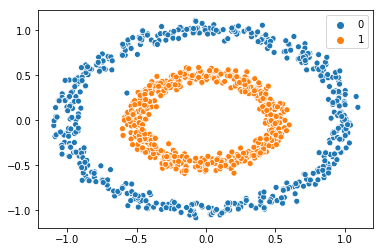

In [11]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=model.predict(X))

### Cost

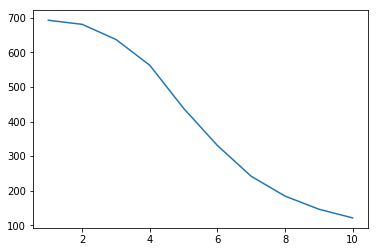

In [12]:
sns.lineplot(x=list(model.C.keys()), y=list(model.C.values()))

### Accuracy

In [13]:
model.score(X, y)

0.999

## Moons Dataset

In [14]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)
X, y = noisy_moons[0], noisy_moons[1]

In [15]:
model = Multilayer(l_in=2, l_hidden=[6], seed=0, alpha=0.01)
model.fit(X, y, max_epoch=150, batch_size=50)

### Predict

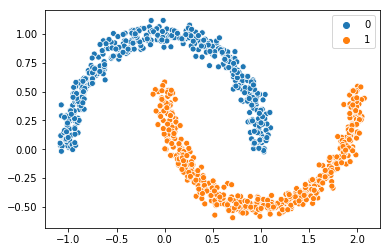

In [16]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=model.predict(X))

### Cost

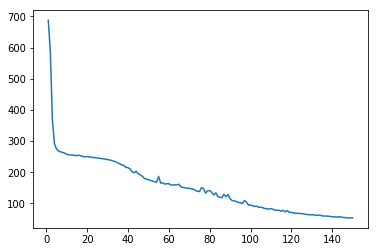

In [17]:
sns.lineplot(x=list(model.C.keys()), y=list(model.C.values()))

### Accuracy

In [18]:
model.score(X, y)

1.0

## Heart Disease

In [19]:
columns = ['age', 'sex', 'cp', 'trestbps','chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat', delimiter=' ', names=columns)

### Preprocessing

In [20]:
real_attributes = [0,3,4,7,9,11]
ordered_attributes = [10]
binary_attributes = [1,5,8]
nominal_attributes = [6,2,12]
target_attribute = 'num'

In [21]:
df[target_attribute] = np.where(df[target_attribute] == 1, 0, 1)

In [22]:
df.iloc[:,real_attributes] = StandardScaler().fit_transform(df.iloc[:,real_attributes])
df.iloc[:,ordered_attributes] = Normalizer().fit_transform(df.iloc[:,ordered_attributes])
df = pd.get_dummies(df, columns=df.columns[nominal_attributes], drop_first=True)

In [23]:
all_fields = list(df.drop(target_attribute, axis=1))

In [24]:
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,num,restecg_1.0,restecg_2.0,cp_2.0,cp_3.0,cp_4.0,thal_6.0,thal_7.0
0,1.712094,1.0,-0.075410,1.402212,0.0,-1.759208,0.0,1.181012,1.0,2.472682,1,0,1,0,0,1,0,0
1,1.382140,0.0,-0.916759,6.093004,0.0,0.446409,0.0,0.481153,1.0,-0.711535,0,0,1,0,1,0,0,1
2,0.282294,1.0,-0.411950,0.219823,0.0,-0.375291,0.0,-0.656118,1.0,-0.711535,1,0,0,1,0,0,0,1
3,1.052186,1.0,-0.187590,0.258589,0.0,-1.932198,1.0,-0.743600,1.0,0.349871,0,0,0,0,0,1,0,1
4,2.152032,0.0,-0.636310,0.374890,0.0,-1.240239,1.0,-0.743600,1.0,0.349871,0,0,1,1,0,0,0,0


### Predict

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df[all_fields], np.array(df[target_attribute]), test_size=0.2)

In [26]:
model = Multilayer(l_in=len(X_train.T), l_hidden=[3], seed=0, alpha=0.01, l2_lambda=0.05)
model.fit(X_train, y_train, max_epoch=200, batch_size=20)

### Cost

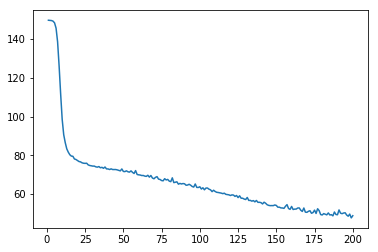

In [27]:
sns.lineplot(x=list(model.C.keys()), y=list(model.C.values()))

### Accuracy

In [28]:
print('train set', model.score(X_train, y_train))
print('test set', model.score(X_test, y_test))

train set 0.9027777777777778
test set 0.8703703703703703
